In [603]:
import numpy as np
import pandas as pd
import statsmodels
from statsmodels import regression, stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
from math import sqrt
from scipy.stats import pearsonr

In [604]:
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data import USEquityPricing
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.factors import AverageDollarVolume
from quantopian.pipeline.filters.morningstar import IsPrimaryShare

Why You Should Hedge Beta and Sector Exposures (Part I)

In [605]:
def make_pipeline():
    
    #Factor returns
    free_cash_flow = Fundamentals.free_cash_flow.latest
    operating_cash_flow = Fundamentals.operating_cash_flow.latest
    total_revenue = Fundamentals.total_revenue.latest
    market_cap = Fundamentals.market_cap.latest > 1e8 # Market_Cap over 100mil
    market_cap0 = Fundamentals.market_cap.latest
    is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
    prices = USEquityPricing.close.latest
   
    universe = (QTradableStocksUS()
                & is_liquid
                & market_cap)
    

    pipe = Pipeline(
        columns={
            'close_prices': prices,
            'free_cash_flow': free_cash_flow,
            'operating_cash_flow': operating_cash_flow,
            'total_revenue': total_revenue,
            'market_cap': market_cap0,

        },
        screen=universe
    )
    
    return pipe
data = run_pipeline(make_pipeline(), start_date='2015-01-01', end_date='2017-01-01')

In [606]:
# Drop missing data
data.dropna(inplace=True)
data.head()

close_prices  free_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])          110.43    9.398000e+09   
                          Equity(1406 [CELG])        111.87    8.424000e+08   
                          Equity(3149 [GE])           25.27    3.198000e+09   
                          Equity(3212 [GILD])         94.34    3.908960e+09   
                          Equity(3443 [HAL])          39.31   -7.100000e+07   

                                                 market_cap  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])    6.473610e+11   
                          Equity(1406 [CELG])  8.934305e+10   
                          Equity(3149 [GE])    2.537662e+11   
                          Equity(3212 [GILD])  1.422067e+11   
                          Equity(3443 [HAL])   3.333061e+10   

                                               operating_cash_flow  \
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])           1.325000e+10   
                          Equity(1406 [CELG])         9.009000e+08   
                          Equity(3149 [GE])           6.035000e+09   
                          Equity(3212 [GILD])         4.044022e+09   
                          Equity(3443 [HAL])          8.380000e+08   

                                               total_revenue  
2015-01-02 00:00:00+00:00 Equity(24 [AAPL])     4.212300e+10  
                          Equity(1406 [CELG])   1.982200e+09  
                          Equity(3149 [GE])     3.617400e+10  
                          Equity(3212 [GILD])   6.041832e+09  
                          Equity(3443 [HAL])    8.701000e+09

In [607]:
asset_list = data.index.levels[1]
prices = get_pricing(asset_list, start_date='2015-01-01', end_date='2017-01-01', fields='price')
prices.columns = map(lambda x: x.symbol, prices.columns)
num_stocks = len(asset_list)
print 'Number of stocks:', num_stocks 
prices.head()

Number of stocks: 151


,AAPL,ABT,TAP,AET,AIG,ALTR,AMAT,AMD,TWX,AMGN,...,KRFT,AMBA,ABBV,COTY,FEYE,TWTR,AAL,GPRO,SYF,PYPL
2015-01-02 00:00:00+00:00,105.130,42.898,71.087,87.174,54.125,36.496,24.033,2.695,81.679,152.620,...,62.254,50.96,61.420,19.879,31.030,36.55,52.859,66.865,29.189,NaN
2015-01-05 00:00:00+00:00,102.196,42.917,70.683,86.016,53.064,36.142,23.281,2.660,80.102,150.910,...,61.469,50.67,60.311,19.840,32.000,36.38,52.830,66.020,29.000,NaN
2015-01-06 00:00:00+00:00,102.177,42.410,70.327,86.124,52.282,35.561,22.404,2.620,79.141,146.039,...,61.479,52.80,59.947,19.636,29.760,38.76,52.006,64.800,28.564,NaN
2015-01-07 00:00:00+00:00,103.639,42.764,72.569,87.822,52.552,35.591,22.616,2.590,79.977,151.178,...,62.791,60.00,62.408,19.762,30.885,37.28,51.967,62.380,28.931,NaN
2015-01-08 00:00:00+00:00,107.602,43.633,74.812,90.747,52.321,36.417,23.329,2.610,82.208,150.528,...,63.606,59.85,63.042,19.933,33.080,39.11,52.614,60.040,29.674,NaN


In [608]:
from sklearn.covariance import LedoitWolf

rets = prices.pct_change().fillna(0) # Calculate returns
lw_cov = LedoitWolf().fit(rets).covariance_ # Calculate Ledoit-Wolf Estimator
symbols = rets.index 

In [609]:
def extract_corr_from_cov(cov_matrix):
    # Linear algebra result:
    # https://math.stackexchange.com/questions/186959/correlation-matrix-from-covariance-matrix
    d = np.linalg.inv(np.diag(np.sqrt(np.diag(cov_matrix))))
    corr = d.dot(cov_matrix).dot(d)
    return corr

In [610]:
tickers = prices.columns
corr = extract_corr_from_cov(lw_cov)

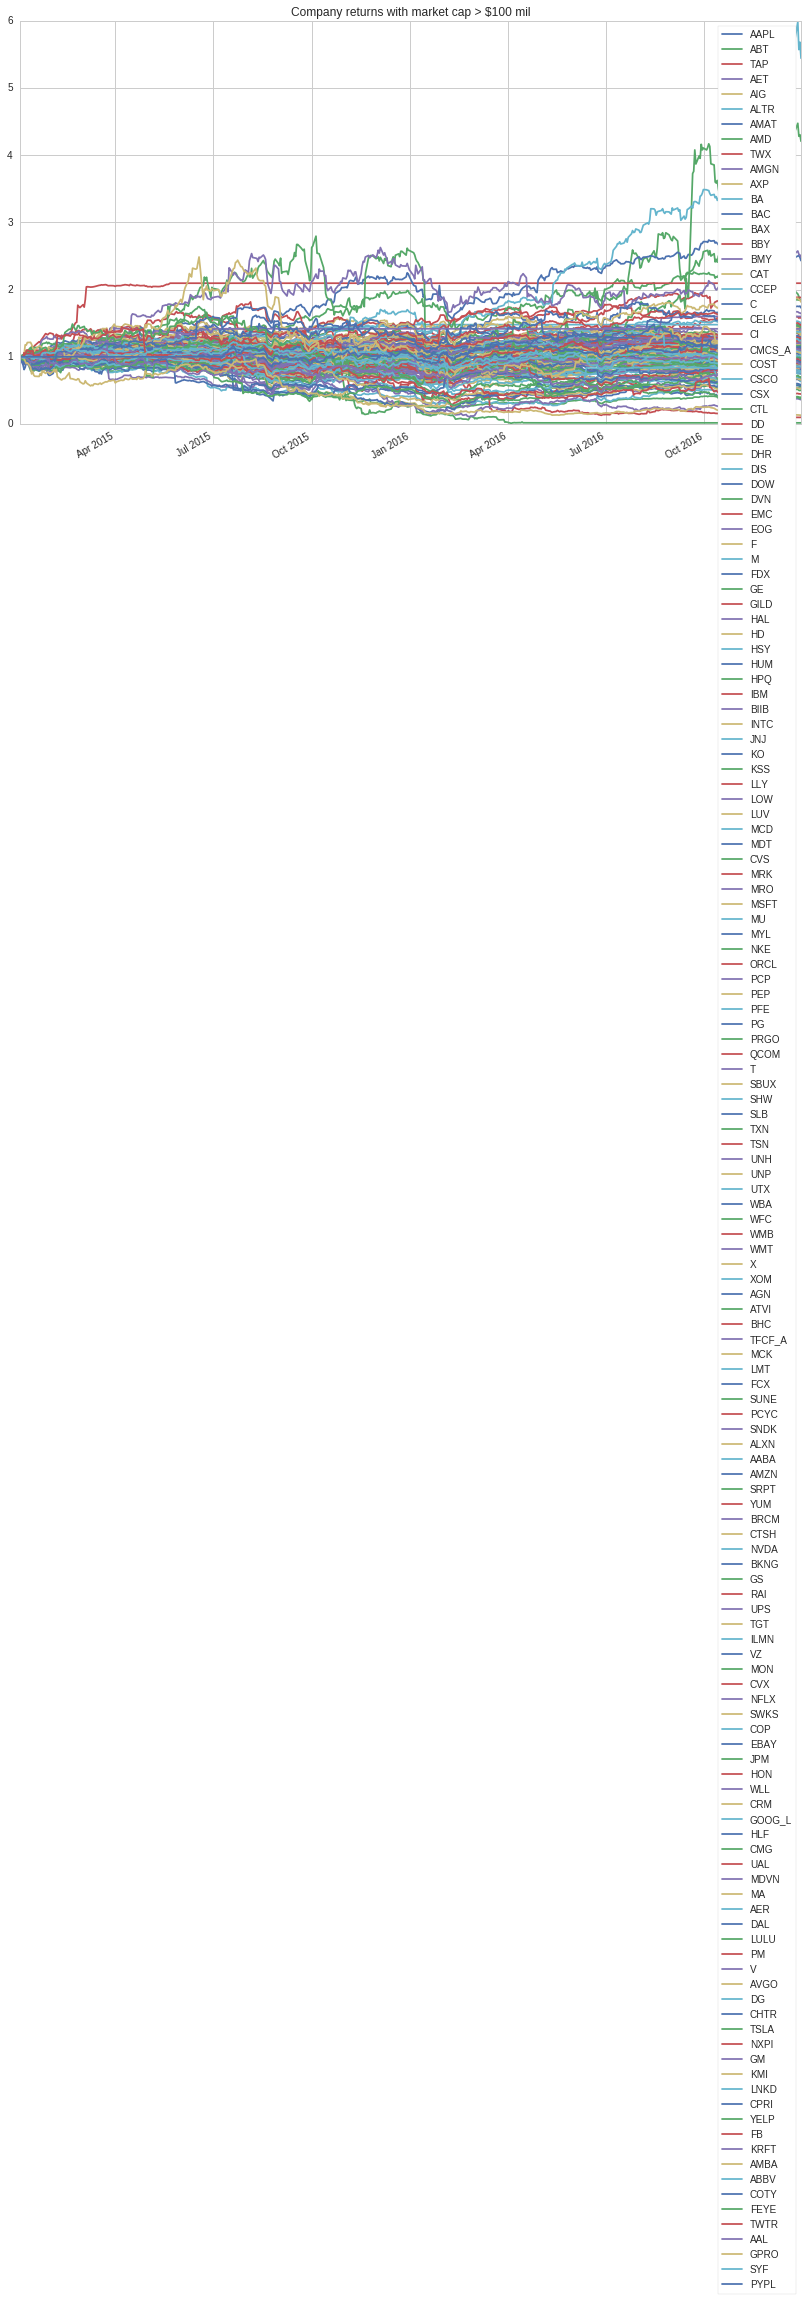

In [726]:
# Plot prices
(1+rets).cumprod().plot()
plt.legend()
plt.title('Company returns with market cap > $100 mil');

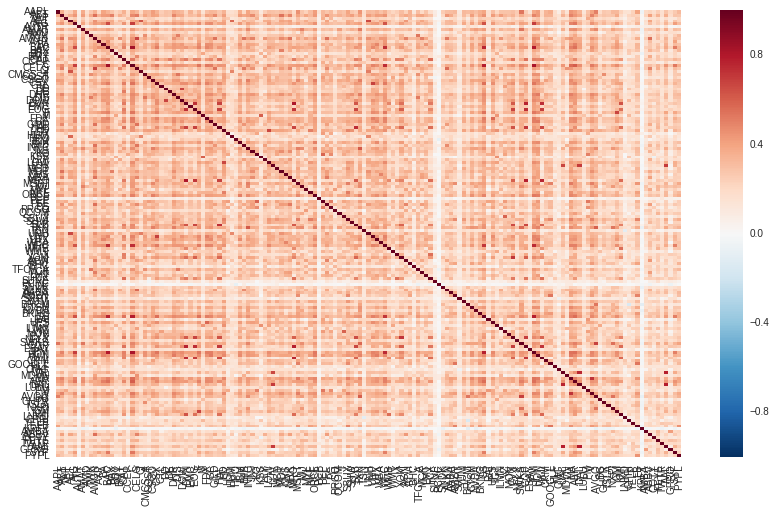

In [612]:
# Plot covariance as a heat map
sns.heatmap(corr, fmt='d', vmin=-1, vmax=1, xticklabels=tickers, yticklabels=tickers);

In [613]:
average_corr = np.mean(corr[np.triu_indices_from(corr, k=1)])
print 'Average pairwise correlation: %.4f' % average_corr

Average pairwise correlation: 0.2428


estimating-covariance-matrices

In [614]:
dates = rets.resample('M').first().index

In [615]:
from sklearn import covariance
returns = rets

In [616]:
sample_covs = []
lw_covs = []

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)
    
    lw_cov = covariance.ledoit_wolf(returns[dates[i-1]:dates[i]])[0]
    lw_covs.append(lw_cov)      

In [617]:
lw_diffs = []
for pair in zip(lw_covs[:-1], lw_covs[1:]):
    diff = np.mean(np.sum(np.abs(pair[0] - pair[1])))
    lw_diffs.append(diff)

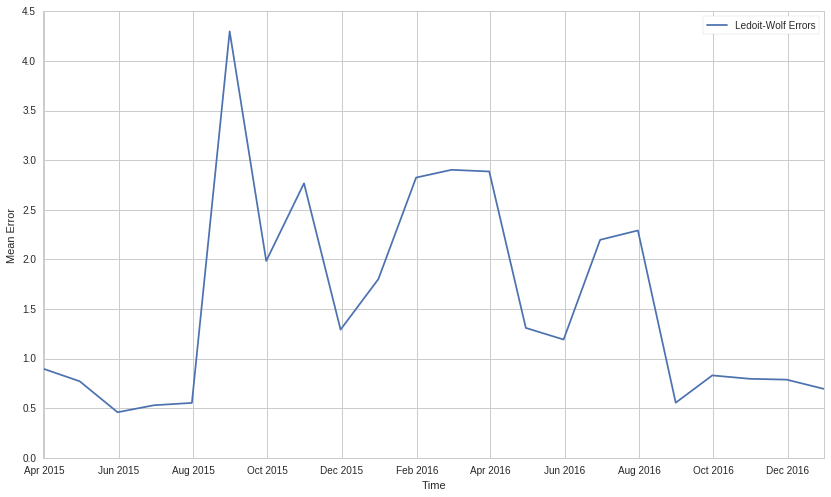

In [725]:
plt.plot(dates[2:], lw_diffs)
plt.xlabel('Time')
plt.ylabel('Mean Error')
plt.legend(['Ledoit-Wolf Errors']);

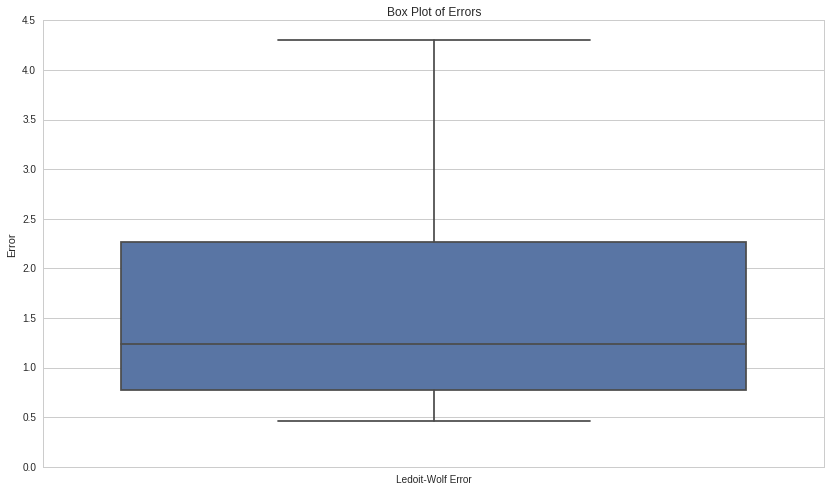

In [619]:
sns.boxplot(
    data = pd.DataFrame({
        'Ledoit-Wolf Error': lw_diffs
    })
)
plt.title('Box Plot of Errors')
plt.ylabel('Error');


Universe Selection

In [620]:
free_cash_flow = Fundamentals.free_cash_flow.latest
operating_cash_flow = Fundamentals.operating_cash_flow.latest
total_revenue = Fundamentals.total_revenue.latest
market_cap = Fundamentals.market_cap.latest > 1e8 # Market_Cap over 100mil
market_cap0 = Fundamentals.market_cap.latest
is_liquid = AverageDollarVolume(window_length=5).percentile_between(99.5, 100)
prices = USEquityPricing.close.latest
   
universe = (QTradableStocksUS()
            & is_liquid
            & market_cap)
    

In [621]:
from quantopian.pipeline.classifiers.fundamentals import Sector  

# Rename our universe to Lectures500
Liquid_120 = universe

SECTOR_CODE_NAMES = {
    Sector.BASIC_MATERIALS: 'Basic Materials',
    Sector.CONSUMER_CYCLICAL: 'Consumer Cyclical',
    Sector.FINANCIAL_SERVICES: 'Financial Services',
    Sector.REAL_ESTATE: 'Real Estate',
    Sector.CONSUMER_DEFENSIVE: 'Consumer Defensive',
    Sector.HEALTHCARE: 'Healthcare',
    Sector.UTILITIES: 'Utilities',
    Sector.COMMUNICATION_SERVICES: 'Communication Services',
    Sector.ENERGY: 'Energy',
    Sector.INDUSTRIALS: 'Industrials',
    Sector.TECHNOLOGY: 'Technology',
    -1 : 'Misc'
}

def get_sector_codes(day, universe):
    pipe = Pipeline(columns={'Sector': Sector()}, screen=universe)
    # Drop the datetime level of the index, since we only have one day of data 
    return run_pipeline(pipe, day, day).reset_index(level=0, drop=True)


def calculate_sector_counts(sectors):
    counts = (sectors.groupby('Sector').size())

    # Replace numeric sector codes with human-friendly names
    counts.index = counts.index.map(lambda code: SECTOR_CODE_NAMES[code])
    return counts

Liquid_120_sectors = get_sector_codes('2017-01-01', Liquid_120)
Liquid_120_counts = calculate_sector_counts(Liquid_120_sectors)

In [622]:
def plot_sector_counts(sector_counts):
    
    bar = plt.subplot2grid((5,5), (0,0), rowspan=2, colspan=5)
    pie = plt.subplot2grid((5,5), (2,0), rowspan=3, colspan=5)
    
    # Bar chart
    sector_counts.plot(
        kind='bar',
        color='b',
        rot=30,
        ax=bar,
    )
    
    bar.set_title('Sector Exposure - Counts')
    
    # Pie chart
    sector_counts.plot(
        kind='pie', 
        colormap='Set3', 
        autopct='%.2f %%',
        fontsize=12,
        ax=pie,
    )
    pie.set_ylabel('')  # This overwrites default ylabel, which is None :(
    pie.set_title('Sector Exposure - Proportions')
    
    plt.tight_layout();

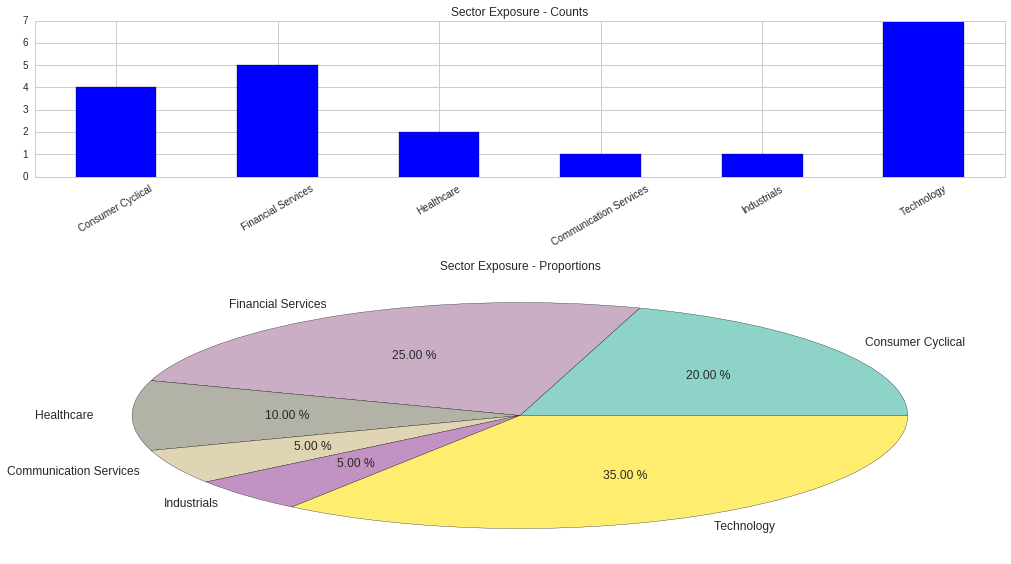

In [623]:
plot_sector_counts(Liquid_120_counts)

In [624]:
res = run_pipeline(Pipeline(columns={'Liquid_120' : Liquid_120}), '2015-01-01', '2017-01-01')
res = res.unstack().fillna(False)

def calculate_daily_turnover(unstacked):
    return (unstacked
            .diff()        # Get True/False showing where values changed from previous day.
            .iloc[1:]      # Drop first row, which is meaningless after diff().
            .astype(bool)  # diff() coerces from bool -> object :(.  Undo that.
            .groupby(axis=1, level=0)  
            .sum())        # Group by universe and count number of True values in each row.

def plot_daily_turnover(unstacked):
    
    # Calculate locations where the inclusion state of an asset changed.
    turnover = calculate_daily_turnover(unstacked)
    
    # Write the data to an axis.
    ax = turnover.plot(figsize=(14, 8))
    
    # Add style to the axis.
    ax.grid(False)
    ax.set_title('Changes per Day')
    ax.set_ylabel('Number of Added or Removed Assets')
    

def print_daily_turnover_stats(unstacked):
    turnover = calculate_daily_turnover(unstacked)
    print(turnover.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

      Liquid_120
mean    3.615079
std     2.221943
25%     2.000000
50%     3.000000
75%     5.000000
min     0.000000
max    11.000000


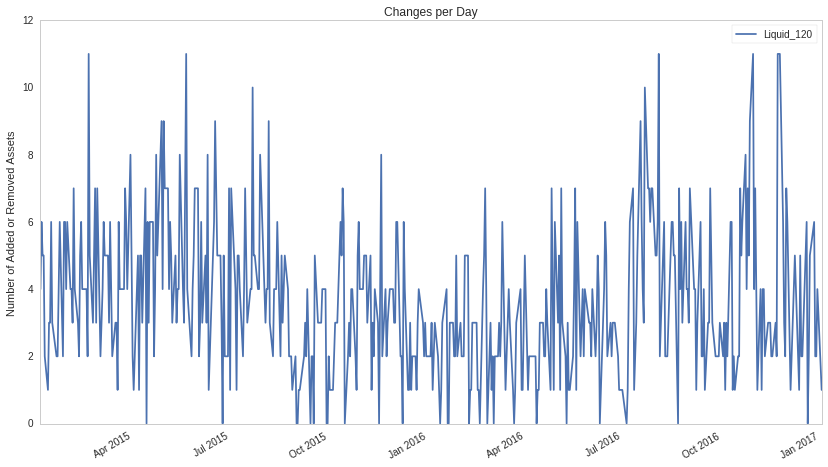

In [625]:
plot_daily_turnover(res)
print_daily_turnover_stats(res)

      Liquid_120 Smoothed
mean             0.603175
std              0.818080
25%              0.000000
50%              0.000000
75%              1.000000
min              0.000000
max              4.000000


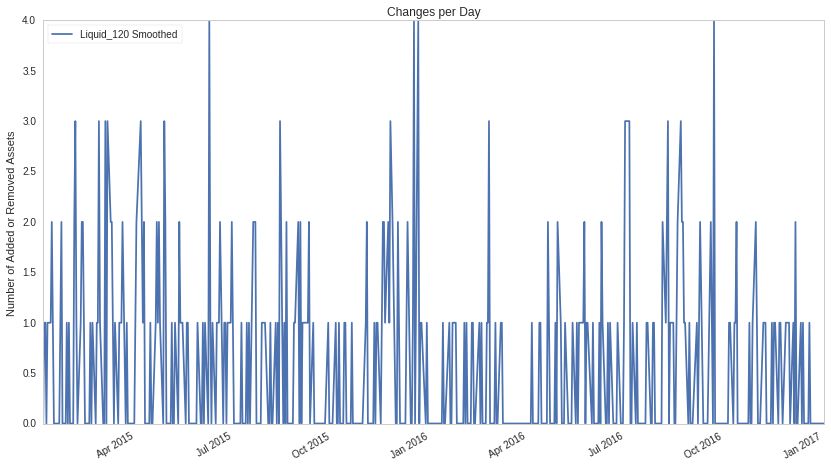

In [626]:
from quantopian.pipeline.filters import AtLeastN

Liquid_120 = AtLeastN(inputs=[Liquid_120],
                       window_length=21,
                       N=10,)

res_smoothed = run_pipeline(Pipeline(columns={'Liquid_120 Smoothed' : Liquid_120}), 
                            '2015-01-01',
                            '2017-01-01')
res_smoothed = res_smoothed.unstack().fillna(False)

plot_daily_turnover(res_smoothed)
print_daily_turnover_stats(res_smoothed)

VaR & CVaR

In [650]:
from scipy.stats import norm

In [651]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=500):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

In [652]:
value_invested = 10000000  

In [653]:
returns = rets
returns = returns - returns.mean(skipna=True) # de-mean the returns

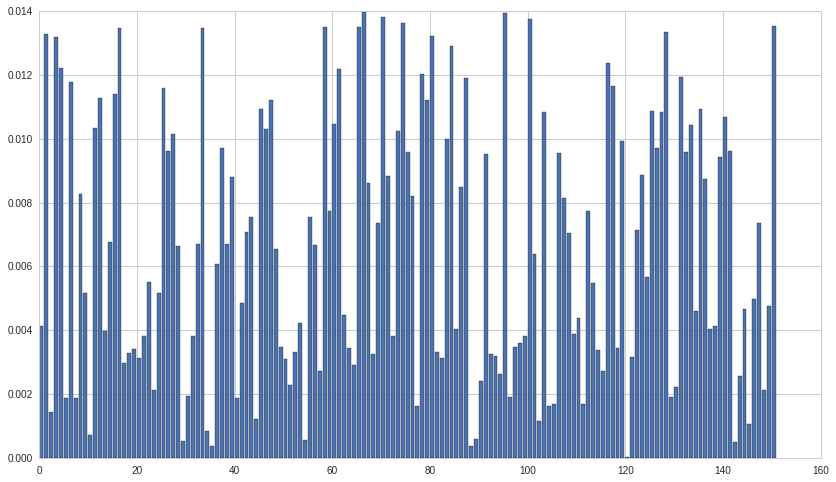

In [654]:
# Random weights
def scale(x):
    return x / np.sum(np.abs(x))

weights_r = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks),weights_r);

In [655]:
# Equal Weights 
eweights_df = len(asset_list) * [float(1)/len(asset_list)]
weights = eweights_df

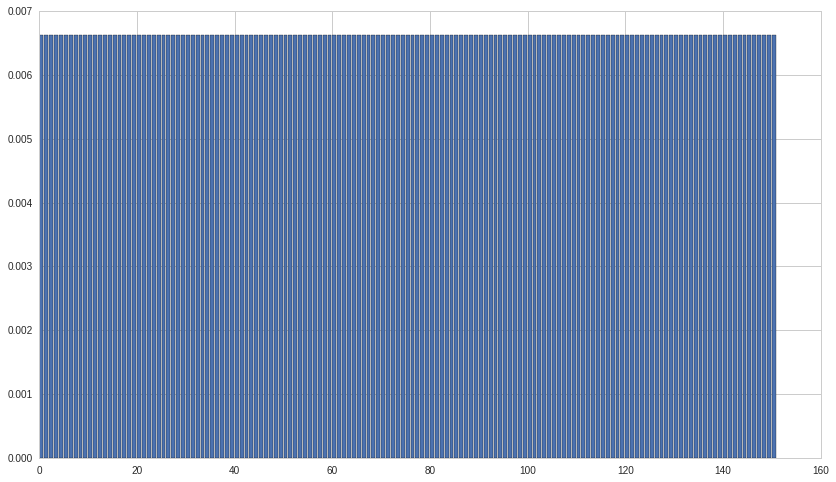

In [656]:
plt.bar(np.arange(num_stocks),weights);

position-concentration-risk

In [657]:
time_start = '2015-01-05'
time_halfway = '2015-06-01'
time_end = '2015-12-31'

In [658]:
def get_markowitz_weights(mu, Sigma, gamma=1, max_position=1.0, max_leverage=1.0, short=False):
    w = cvxpy.Variable(len(Sigma))
    g = cvxpy.Parameter(sign='positive')
    L = cvxpy.Parameter()
    g.value = gamma
    L.value = max_leverage
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    risk = cvxpy.quad_form(w, Sigma)
    
    objective = cvxpy.Maximize(ret - g*risk)
    constraints = [
        cvxpy.abs(w) < max_position,
        cvxpy.norm(w, 1) <= L, # Make it so we don't have to invest everything
    ]
    
    if not short:
        constraints.append(w >= 0) # Force all positive weights
    
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    return w.value

In [659]:
mu = rets[tickers].\
        loc[:time_halfway].fillna(0).mean().as_matrix()
sigma = rets[tickers].\
        loc[:time_halfway].fillna(0).cov().as_matrix()

mkweights_df = get_markowitz_weights(mu, sigma)

In [660]:
# markowitz_weights 
weights_mkw = mkweights_df

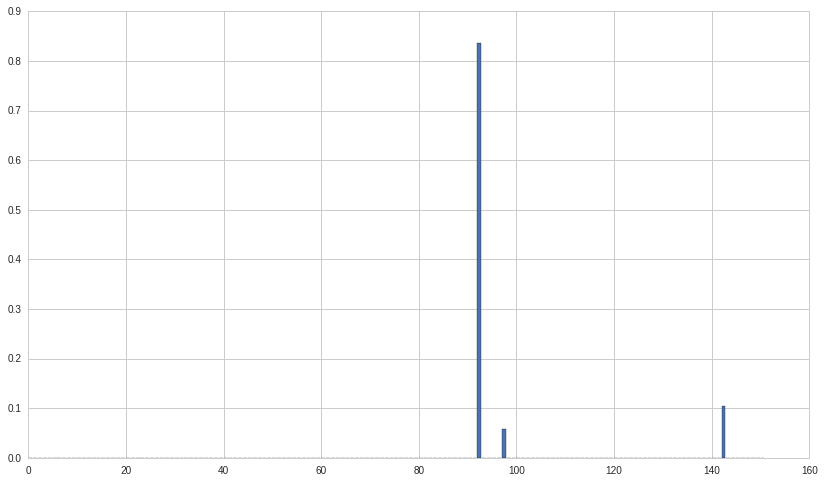

In [661]:
plt.bar(np.arange(num_stocks),weights_mkw);

In [662]:
value_at_risk(value_invested, returns, weights_mkw, alpha=0.95, lookback_days=500)

-118487.37058639637

In [663]:
value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=500)

-156649.60978565941

In [664]:
value_at_risk(value_invested, returns, weights_r, alpha=0.95, lookback_days=500)

-154416.56243999104

In [665]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=500):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

In [666]:
cvar(value_invested, returns, weights_mkw, lookback_days=500)

-167413.44743929658

In [667]:
cvar(value_invested, returns, weights, lookback_days=500)

-246031.80003413904

In [668]:
cvar(value_invested, returns, weights_r, lookback_days=500)

-249196.26939333259

mean    0.000035
std     0.009953
25%    -0.004826
50%     0.000153
75%     0.005944
min    -0.040518
max     0.036693
dtype: float64


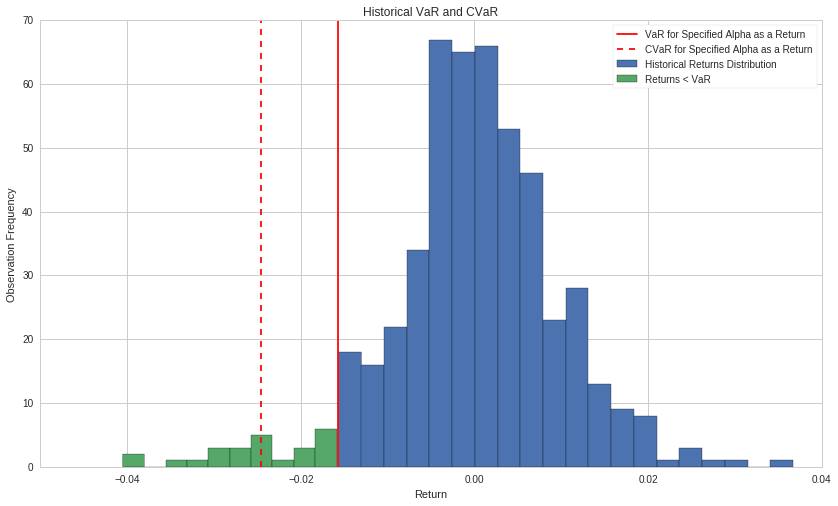

In [669]:
lookback_days = 500
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean   -0.181750
std     0.627397
25%          NaN
50%          NaN
75%          NaN
min    -2.595295
max     1.741747
dtype: float64


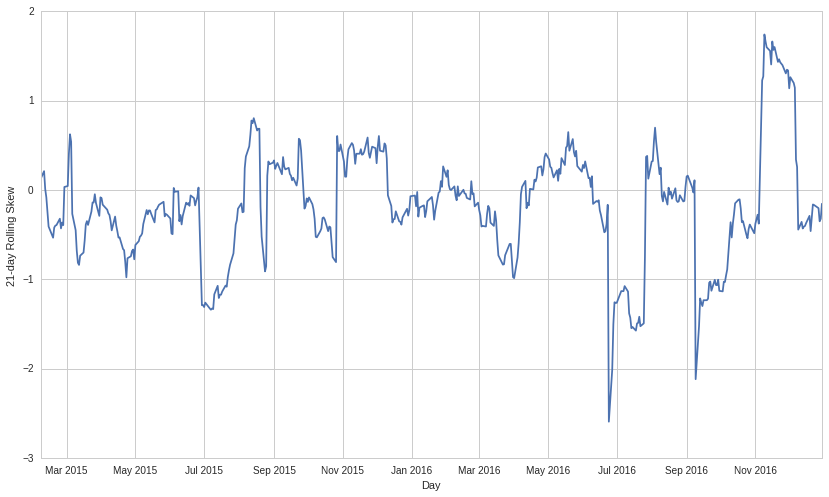

In [670]:
rolling_skew = portfolio_returns.rolling(window=21,center=False).skew()
plt.plot(rolling_skew)
plt.xlabel('Day')
plt.ylabel('21-day Rolling Skew');
print(rolling_skew.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']]);

In [671]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print 'The portfolio returns are likely normal.'
else:
    print 'The portfolio returns are likely not normal.'

The portfolio returns are likely not normal.


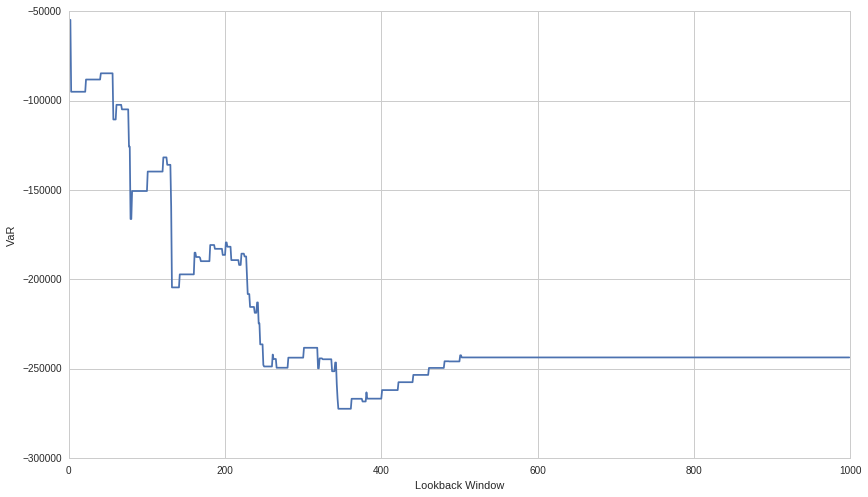

In [672]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

In [673]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print 'Process is likely stationary.'
else:
    print 'Process is likely non-stationary.'

Process is likely stationary.


instability-of-estimates

mean    0.000035
std     0.009953
25%    -0.004826
50%     0.000153
75%     0.005944
min    -0.040518
max     0.036693
dtype: float64


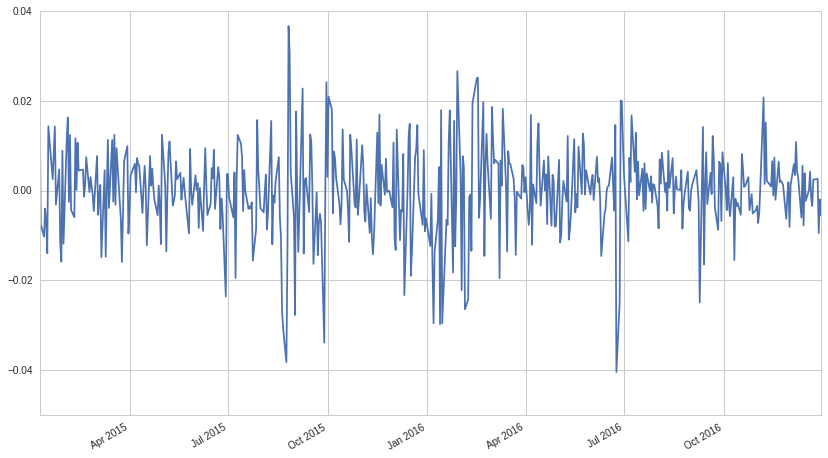

In [674]:
portfolio_returns.plot();
print(portfolio_returns.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

In [675]:
portfolio_returns_mean = portfolio_returns.rolling(window=21).mean()
portfolio_returns_std = portfolio_returns.rolling(window=21).std()

mean    0.000051
std     0.001989
25%          NaN
50%          NaN
75%          NaN
min    -0.006597
max     0.006745
dtype: float64


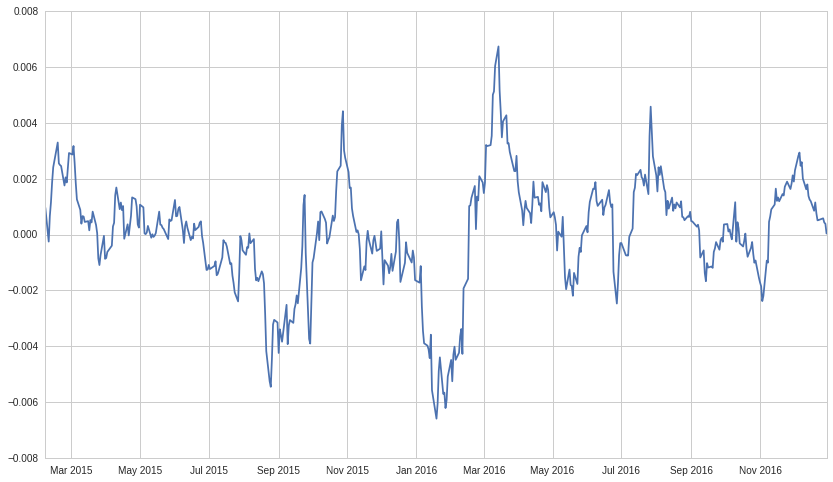

In [676]:
plt.plot(portfolio_returns_mean);
print(portfolio_returns_mean.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean    0.009299
std     0.003775
25%          NaN
50%          NaN
75%          NaN
min     0.004280
max     0.020105
dtype: float64


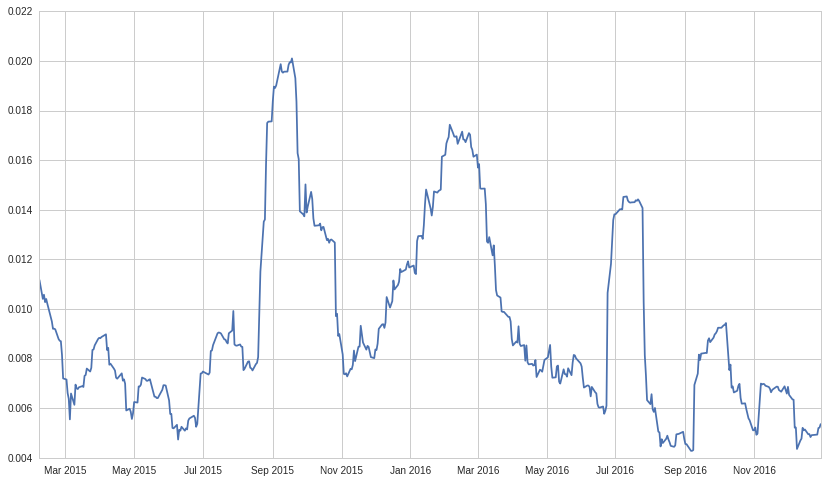

In [677]:
plt.plot(portfolio_returns_std);
print(portfolio_returns_std.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

CAPM & Arbitrage

In [678]:
start_date = '2015-01-01'
end_date = '2017-01-01'

# We will look at the returns of an asset one-month into the future to model future returns.
offset_start_date = '2015-02-02'
offset_end_date = '2017-02-02'

# Get returns data for our assets
asset1 = portfolio_returns
# Get returns for the market
bench = get_pricing('SPY', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]
# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing('BIL', fields='price', start_date=start_date, end_date=end_date).pct_change()[1:]

In [679]:
# Define a constant to compute intercept
constant = pd.Series(np.ones(len(asset1.index)), index=asset1.index)


df = pd.DataFrame({'portfolio': asset1,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

In [680]:
OLS_model = regression.linear_model.OLS(df['portfolio'], df[['SPY', 'RF', 'Constant']])
fitted_model = OLS_model.fit()
R1_params = fitted_model.params

In [681]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              portfolio   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     2840.
Date:                Thu, 11 Apr 2019   Prob (F-statistic):          1.05e-272
Time:                        22:58:02   Log-Likelihood:                 2226.0
No. Observations:                 500   AIC:                            -4446.
Df Residuals:                     497   BIC:                            -4433.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SPY            1.0614      0.014     75.256      0.000         1.034     1.089
RF            -1.0954      0.983     -1.114      0.266        -3.027     0.836
Constant      -0.0003      0.000     -2.437      0.015        -0.001 -5.98e-05
==============================================================================
Omnibus:                       13.440   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.094
Skew:                          -0.253   Prob(JB):                     0.000118
Kurtosis:                       3.782   Cond. No.                     7.77e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

           SPY        RF  intercept
mean  1.067928 -0.944335  -0.000361
std   0.059197  2.696646   0.000374
25%   1.017606 -3.235784  -0.000637
50%   1.069764 -1.282677  -0.000324
75%   1.118125  1.351183  -0.000061
min   0.965009 -5.926561  -0.001198
max   1.171443  4.814066   0.000280


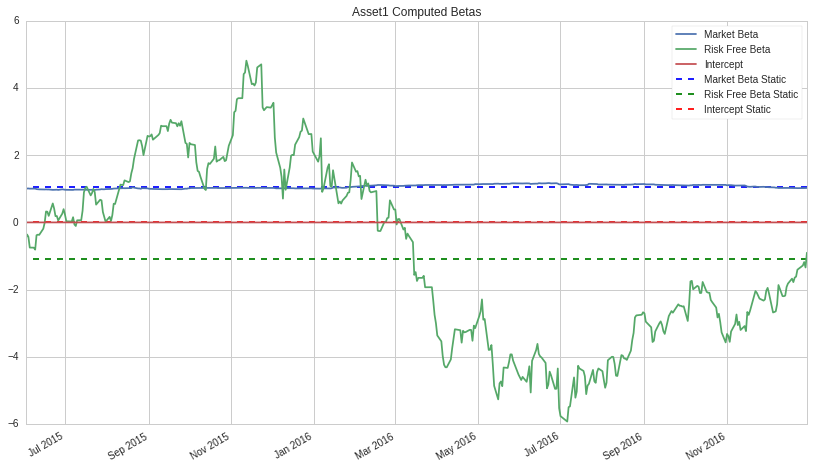

In [682]:
model = pd.stats.ols.MovingOLS(y = df['portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates.plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')
plt.hlines(R1_params['RF'], df.index[0], df.index[-1], linestyles='dashed', colors='green')
plt.hlines(R1_params['Constant'], df.index[0], df.index[-1], linestyles='dashed', colors='red')

plt.title('Asset1 Computed Betas');
plt.legend(['Market Beta', 'Risk Free Beta', 'Intercept', 'Market Beta Static', 'Risk Free Beta Static', 'Intercept Static']);
print(rolling_parameter_estimates.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

mean    1.067928
std     0.059197
25%     1.017606
50%     1.069764
75%     1.118125
min     0.965009
max     1.171443
Name: SPY, dtype: float64


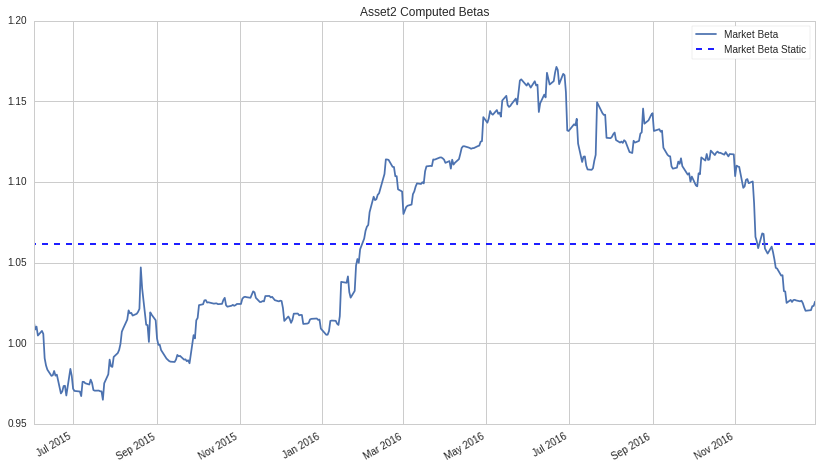

In [683]:
model = pd.stats.ols.MovingOLS(y = df['portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();

plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')

plt.title('Asset2 Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);
print(rolling_parameter_estimates['SPY'].describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

beta-hedging

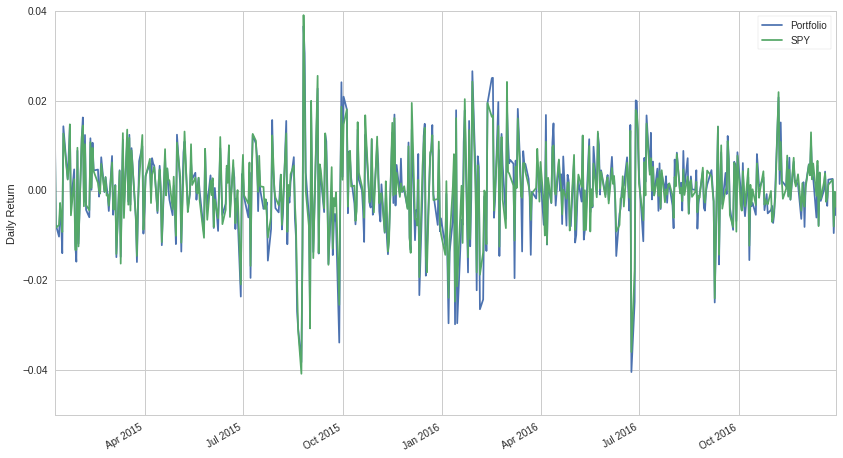

In [684]:
# We have to take the percent changes to get to returns
# Get rid of the first (0th) element because it is NAN
r_a = df['portfolio']
r_b = df['SPY']

# Let's plot them just for fun
r_a.plot()
r_b.plot()
plt.ylabel("Daily Return")
plt.legend(['Portfolio', 'SPY']);

In [685]:
# Let's define everything in familiar regression terms
X = r_b.values # Get just the values, ignore the timestamps
Y = r_a.values

def linreg(x,y):
    # We add a constant so that we can also fit an intercept (alpha) to the model
    # This just adds a column of 1s to our data
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y,x).fit()
    # Remove the constant now that we're done
    x = x[:, 1]
    return model.params[0], model.params[1]

alpha, beta = linreg(X,Y)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: -0.000308205018543
beta: 1.06206812626


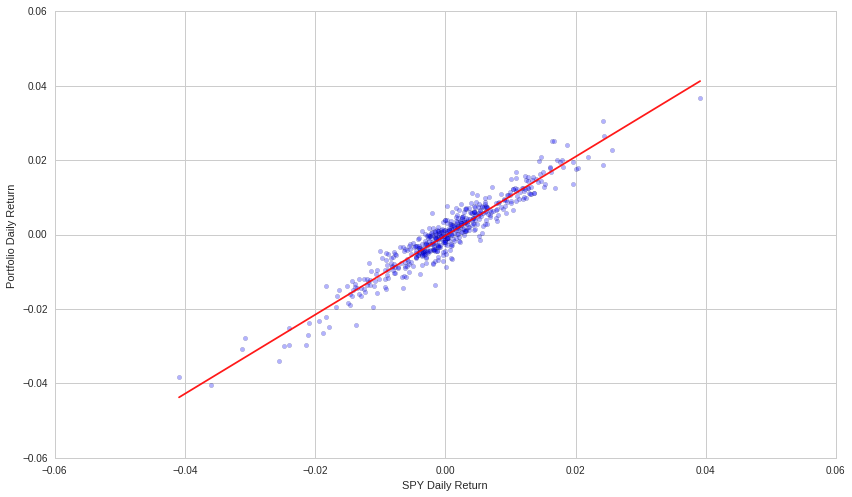

In [686]:
X2 = np.linspace(X.min(), X.max(), 100)
Y_hat = X2 * beta + alpha

plt.scatter(X, Y, alpha=0.3) # Plot the raw data
plt.xlabel("SPY Daily Return")
plt.ylabel("Portfolio Daily Return")

 # Add the regression line, colored in red
plt.plot(X2, Y_hat, 'r', alpha=0.9);

mean   -0.000308
std     0.002826
25%    -0.001955
50%    -0.000156
75%     0.001466
min    -0.011874
max     0.007898
Name: Portfolio + Hedge, dtype: float64


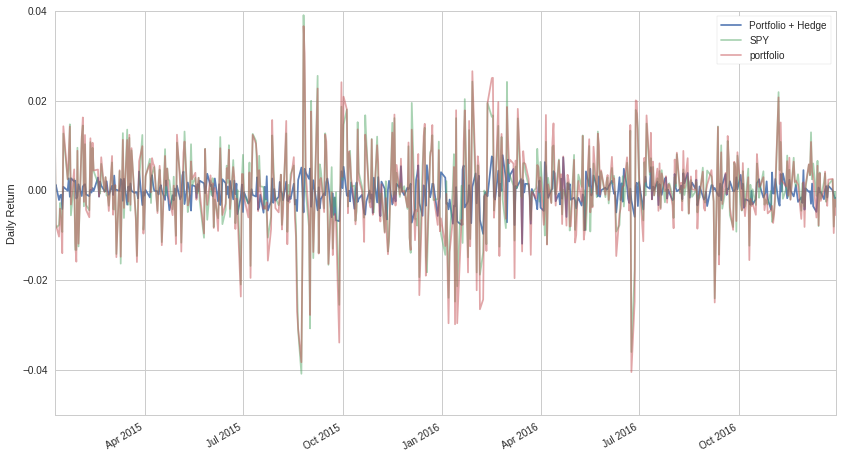

In [687]:
# Construct a portfolio with beta hedging
portfolio = -1*beta*r_b + r_a
portfolio.name = "Portfolio + Hedge"

# Plot the returns of the portfolio as well as the asset by itself
portfolio.plot(alpha=0.9)
r_b.plot(alpha=0.5);
r_a.plot(alpha=0.5);
plt.ylabel("Daily Return")
plt.legend();
print(portfolio.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']]);

In [688]:
P = portfolio.values
alpha, beta = linreg(X,P)
print 'alpha: ' + str(alpha)
print 'beta: ' + str(beta)

alpha: -0.000308205018543
beta: 1.64798730218e-16


In [689]:
rolling_corr = portfolio.rolling(window=21).corr(r_b)

mean   -0.041182
std     0.293278
25%          NaN
50%          NaN
75%          NaN
min    -0.664633
max     0.600281
dtype: float64


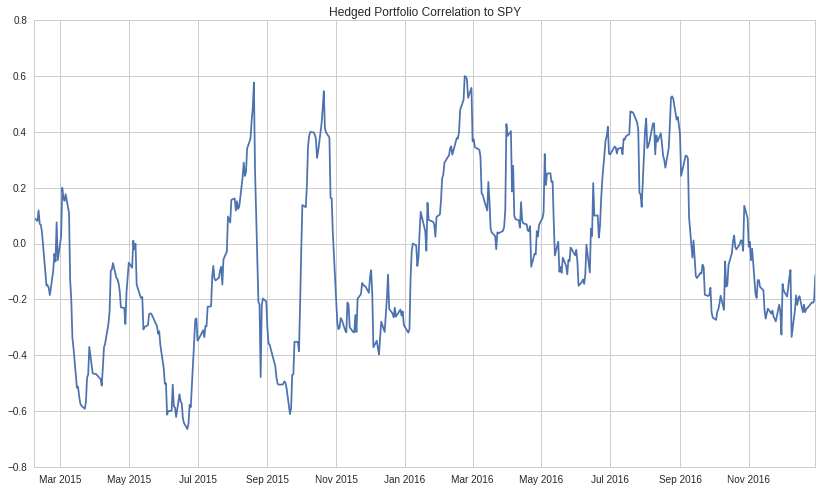

In [690]:
plt.plot(rolling_corr);
plt.title('Hedged Portfolio Correlation to SPY')
print(rolling_corr.describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']]);

In [691]:
df = pd.DataFrame({'hedged_portfolio': portfolio,
              'SPY': bench,
              'RF': treasury_ret,
              'Constant': constant})
df = df.dropna()

mean    0.005860
std     0.059197
25%    -0.044462
50%     0.007696
75%     0.056056
min    -0.097059
max     0.109375
Name: SPY, dtype: float64


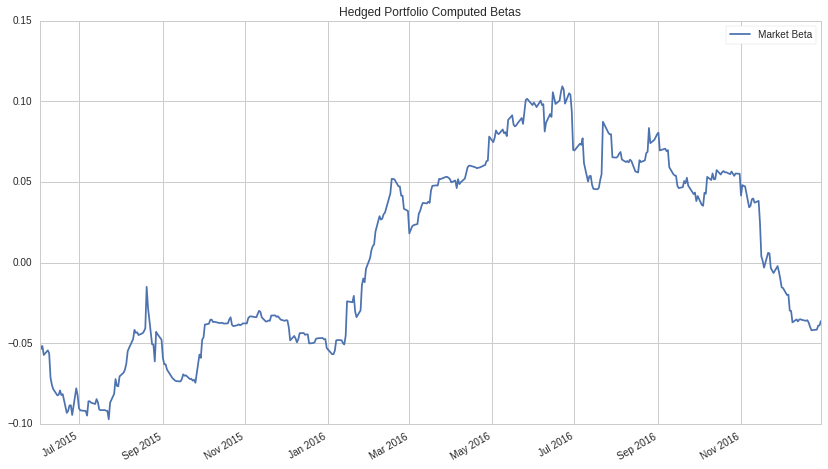

In [694]:
model = pd.stats.ols.MovingOLS(y = df['hedged_portfolio'], x=df[['SPY', 'RF']], 
                             window_type='rolling', 
                             window=100)
rolling_parameter_estimates = model.beta
rolling_parameter_estimates['SPY'].plot();
#plt.hlines(R1_params['SPY'], df.index[0], df.index[-1], linestyles='dashed', colors='blue')

plt.title('Hedged Portfolio Computed Betas');
plt.legend(['Market Beta', 'Market Beta Static']);
print(rolling_parameter_estimates['SPY'].describe().loc[['mean', 'std', '25%', '50%', '75%', 'min', 'max']])

instability-of-estimates

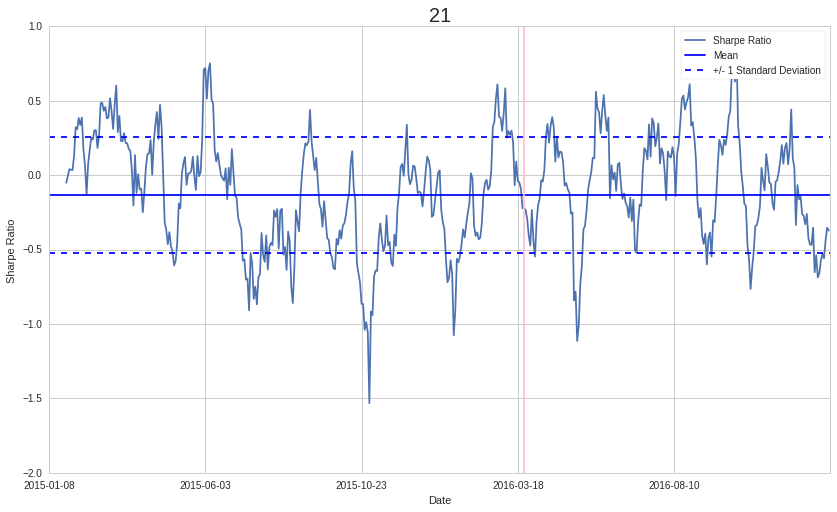

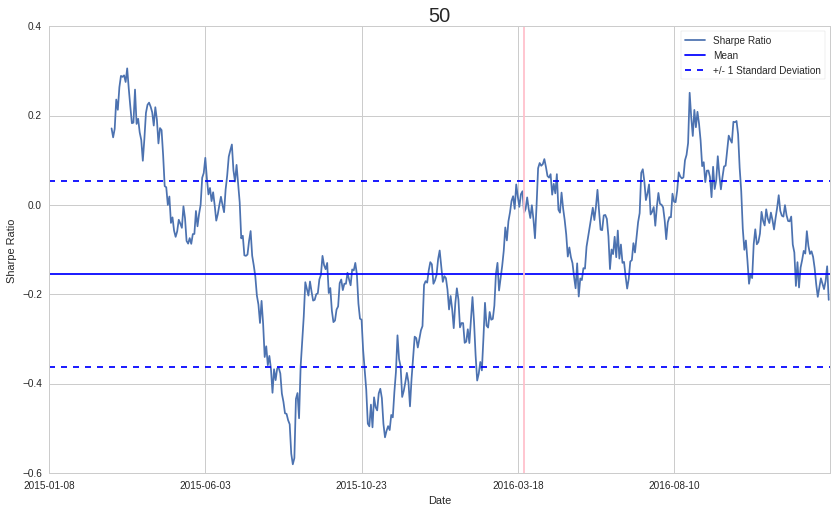

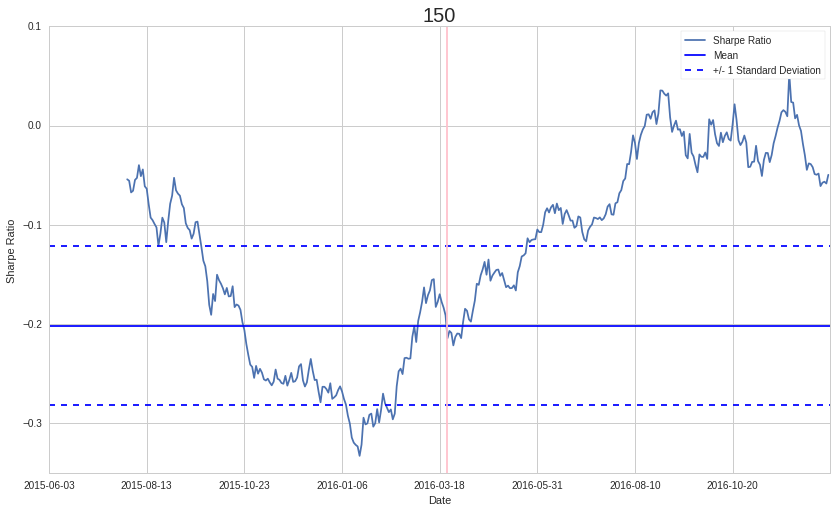

In [706]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree)/np.std(asset - riskfree)

for window in [21, 50, 150]:
    running_sharpe = [sharpe_ratio(portfolio[i-window+10:i], treasury_ret[i-window+10:i]) for i in range(window-10, len(portfolio))]
    mean_rs = np.mean(running_sharpe[:-200])
    std_rs = np.std(running_sharpe[:-200])
    
    _, ax2 = plt.subplots()
    
    ax2.plot(range(window-10, len(portfolio)), running_sharpe)
    ticks = ax2.get_xticks()

    ax2.set_xticklabels([portfolio.index[i].date() for i in ticks[:-1]])
    
    ax2.axhline(mean_rs)
    ax2.axhline(mean_rs + std_rs, linestyle='--')
    ax2.axhline(mean_rs - std_rs, linestyle='--')
    
    ax2.axvline(len(returns) - 200, color='pink');
    plt.title(window, fontsize = 20)
    plt.xlabel('Date')
    plt.ylabel('Sharpe Ratio')
    plt.legend(['Sharpe Ratio', 'Mean', '+/- 1 Standard Deviation'])

risk-constrained-portfolio-optimization

In [707]:
from quantopian.pipeline.factors import CustomFactor, Returns

In [708]:
assets = tickers
universe0 = universe

In [709]:
# date range for building risk model
start = "2015-01-01"
end = "2017-01-01"

In [710]:
def qtus_returns(start_date, end_date):
    pipe = Pipeline(
        columns={'Close': USEquityPricing.close.latest},
        screen = universe0
    )
    stocks = run_pipeline(pipe, start_date, end_date)  
    unstacked_results = stocks.unstack()
    
    prices = (unstacked_results['Close'].fillna(method='ffill').fillna(method='bfill')
                  .dropna(axis=1,how='any').shift(periods=-1).dropna())  
    qus_returns = prices.pct_change()[1:]
    return qus_returns


R = qtus_returns(start, end)
print "The universe we define includes {} assets.".format(R.shape[1])
print 'The number of timestamps is {} from {} to {}.'.format(R.shape[0], start, end)

The universe we define includes 151 assets.
The number of timestamps is 503 from 2015-01-01 to 2017-01-01.


In [711]:
assets = R.columns

In [712]:
def make_pipeline():
    """
    Create and return our pipeline.
    
    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation.
    
    In particular, this function can be copy/pasted into the backtester and run by itself.
    """
    # Market Cap
    market_cap = Fundamentals.shares_outstanding.latest/USEquityPricing.close.latest
    # Book to Price ratio
    book_to_price = 1/Fundamentals.pb_ratio.latest
    
    # Build Filters representing the top and bottom 500 stocks by our combined ranking system.
    biggest = market_cap.top(500, mask=QTradableStocksUS())
    smallest = market_cap.bottom(500, mask=QTradableStocksUS())
    
    highpb = book_to_price.top(500, mask=QTradableStocksUS())
    lowpb = book_to_price.bottom(500, mask=QTradableStocksUS())
    
    universe = biggest | smallest | highpb | lowpb
    
    pipe = Pipeline(
        columns = {
            'returns' : Returns(window_length=2),
            'market_cap' : market_cap,
            'book_to_price' : book_to_price,
            'biggest' : biggest,
            'smallest' : smallest,
            'highpb' : highpb,
            'lowpb' : lowpb
        },
        screen=universe
    )
    return pipe

In [713]:
pipe = make_pipeline()
# This takes a few minutes.
results = run_pipeline(pipe, start, end)
R_biggest = results[results.biggest]['returns'].groupby(level=0).mean()
R_smallest = results[results.smallest]['returns'].groupby(level=0).mean()

R_highpb = results[results.highpb]['returns'].groupby(level=0).mean()
R_lowpb = results[results.lowpb]['returns'].groupby(level=0).mean()

SMB = R_smallest - R_biggest
HML = R_highpb - R_lowpb

df = pd.DataFrame({
         'SMB': SMB, # company size
         'HML': HML  # company PB ratio
    },columns =["SMB","HML"]).shift(periods =-1).dropna()

MKT = get_pricing('SPY', start_date=start, end_date=end, fields='price').pct_change()[1:]
MKT = pd.DataFrame({'MKT':MKT})

F = pd.concat([MKT,df],axis = 1).dropna()

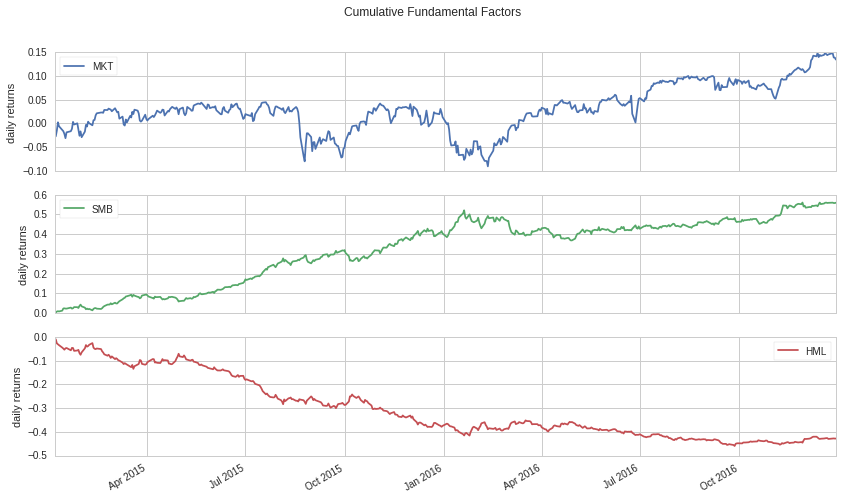

In [714]:
ax = ((F + 1).cumprod() - 1).plot(subplots=True, title='Cumulative Fundamental Factors')
ax[0].set(ylabel = "daily returns")
ax[1].set(ylabel = "daily returns")
ax[2].set(ylabel = "daily returns")
plt.show()

In [715]:
# factor exposure
B = pd.DataFrame(index=assets, dtype=np.float32)
epsilon = pd.DataFrame(index=R.index, dtype=np.float32)

In [716]:
x = sm.add_constant(F)

for i in assets:
    y = R.loc[:,i]
    y_inlier = y[np.abs(y - y.mean())<=(3*y.std())]
    x_inlier = x[np.abs(y - y.mean())<=(3*y.std())]
    result = sm.OLS(y_inlier, x_inlier).fit()

    B.loc[i,"MKT_beta"] = result.params[1]
    B.loc[i,"SMB_beta"] = result.params[2]
    B.loc[i,"HML_beta"] = result.params[3]
    epsilon.loc[:,i] = y - (x.iloc[:,0] * result.params[0] +
                            x.iloc[:,1] * result.params[1] + 
                            x.iloc[:,2] * result.params[2] +
                            x.iloc[:,3] * result.params[3])
 

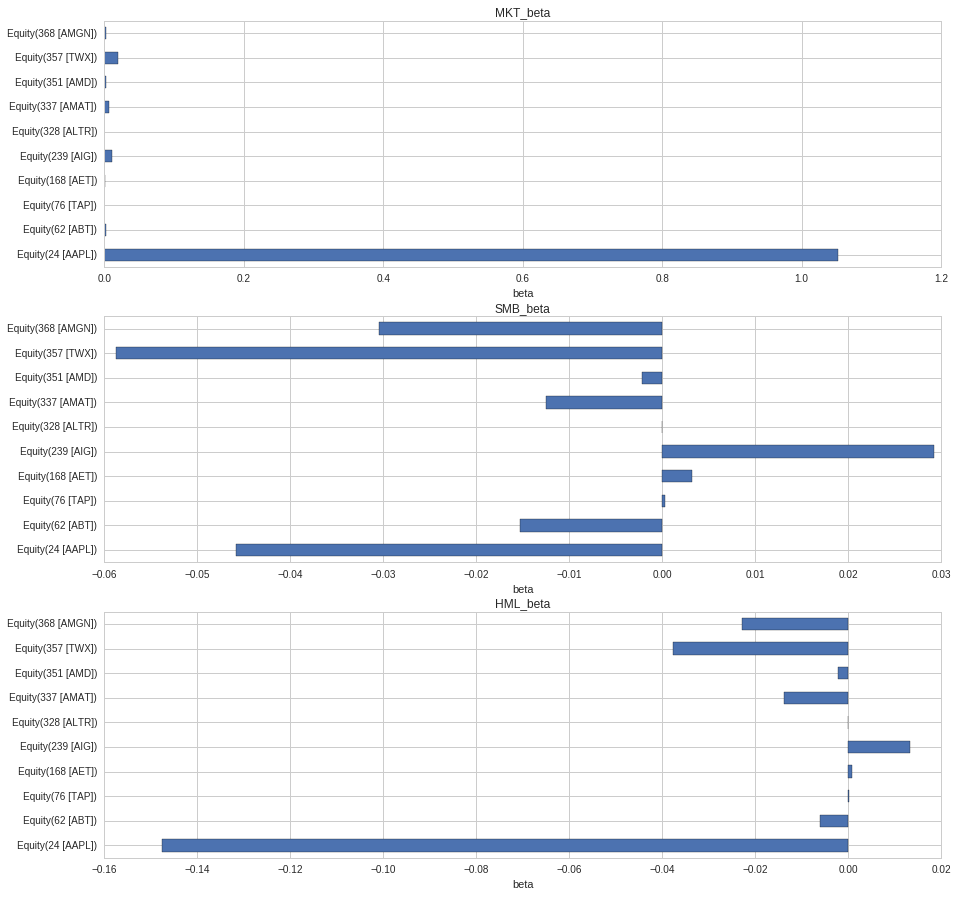

In [717]:
fig,axes = plt.subplots(3, 1)
ax1,ax2,ax3 =axes

B.iloc[0:10,0].plot.barh(ax=ax1, figsize=[15,15], title=B.columns[0])
B.iloc[0:10,1].plot.barh(ax=ax2, figsize=[15,15], title=B.columns[1])
B.iloc[0:10,2].plot.barh(ax=ax3, figsize=[15,15], title=B.columns[2])

ax1.set(xlabel='beta')
ax2.set(xlabel='beta')
ax3.set(xlabel='beta')
plt.show()

In [718]:
F.head()

,MKT,SMB,HML
2015-01-05 00:00:00+00:00,-0.017526,0.005529,-0.012682
2015-01-06 00:00:00+00:00,-0.009764,-0.001746,0.002699
2015-01-07 00:00:00+00:00,0.012511,0.004667,-0.017315
2015-01-08 00:00:00+00:00,0.017694,0.001661,-0.003974
2015-01-09 00:00:00+00:00,-0.008354,-0.001101,-0.003827


In [719]:
B.head()

,MKT_beta,SMB_beta,HML_beta
Equity(24 [AAPL]),1.052196,-0.045793,-0.147469
Equity(62 [ABT]),0.002568,-0.015314,-0.006040
Equity(76 [TAP]),0.000121,0.000273,0.000166
Equity(168 [AET]),0.001236,0.003155,0.000845
Equity(239 [AIG]),0.011155,0.029227,0.013241


In [720]:
w = np.ones([1,R.shape[1]])/R.shape[1]

In [721]:
def compute_common_factor_variance(factors, factor_exposures, w):   
    B = np.asarray(factor_exposures)
    F = np.asarray(factors)
    V = np.asarray(factors.cov())
    
    return w.dot(B.dot(V).dot(B.T)).dot(w.T)

common_factor_variance = compute_common_factor_variance(F, B, w)[0][0]
print("Common Factor Variance: {0}".format(common_factor_variance))

Common Factor Variance: 1.54484558162e-06


In [722]:
def compute_specific_variance(epsilon, w):       
    
    D = np.diag(np.asarray(epsilon.var())) * epsilon.shape[0] / (epsilon.shape[0]-1)

    return w.dot(D).dot(w.T)

specific_variance = compute_specific_variance(epsilon, w)[0][0]
print("Specific Variance: {0}".format(specific_variance))

Specific Variance: 1.08546229433e-06


In [723]:
common_factor_pct = common_factor_variance/(common_factor_variance + specific_variance)*100.0
print("Percentage of Portfolio Variance Due to Common Factor Risk: {0:.2f}%".format(common_factor_pct))

Percentage of Portfolio Variance Due to Common Factor Risk: 58.73%
